## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tqdm.notebook import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/ML Project/Womens Clothing E-Commerce Reviews.csv')

## Data Preprocessing

In [ ]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

Drop Some Features

In [ ]:
df = df.drop(['Unnamed: 0', 'Clothing ID', 'Positive Feedback Count', 'Division Name'], axis=1)

Combine Rating, Age, Department, Class, Title and Review

In [ ]:
df['Combined Text'] = df.apply(lambda row: f"{row['Title']}. {row['Review Text']}" if not pd.isna(row['Title']) else f"{row['Review Text']}", axis=1)

Lowercase

In [ ]:
df['Combined Text'] = df['Combined Text'].str.lower()

In [ ]:
df.shape

(23486, 8)

In [ ]:
df.head(5)

,Age,Title,Review Text,Rating,Recommended IND,Department Name,Class Name,Combined Text
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,Intimate,Intimates,absolutely wonderful - silky and sexy and comf...
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,Dresses,Dresses,love this dress! it's sooo pretty. i happene...
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,Dresses,Dresses,some major design flaws. i had such high hopes...
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,Bottoms,Pants,"my favorite buy!. i love, love, love this jump..."
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,Tops,Blouses,flattering shirt. this shirt is very flatterin...


In [ ]:
df['Recommended IND'].value_counts(normalize=True)

1    0.822362
0    0.177638
Name: Recommended IND, dtype: float64

Train-Validation-Test Split

In [ ]:
X = df['Combined Text'].values
y = df['Recommended IND'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, X_val.shape, X_test.shape

((16440,), (3523,), (3523,))

## Data Formatting

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Find Max Token Length

In [ ]:
token_length = np.array([len(tokenizer.encode(row, add_special_tokens=True)) for row in tqdm(X)])
max_token_length = max(token_length)

  0%|          | 0/23486 [00:00<?, ?it/s]

In [ ]:
X_train_tokens = tokenizer(
    X_train.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

X_val_tokens = tokenizer(
    X_val.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

X_test_tokens = tokenizer(
    X_test.tolist(),
    add_special_tokens=True,
    max_length=max_token_length,
    pad_to_max_length=True,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='tf'
)

## Model Architecture

1. Input Layer:
  * Shape: (max_token_length,)
  * Takes input ids and attention masks.

2. RoBERTa Layer:
  * Pre-Trained RoBERTa model for sequence classification.
  * Produces 'logits' as pooled output.

3. Output Layer:
  * Dense layer with Sigmoid activation function (1 unit).

In [ ]:
def create_model():
    input_ids = Input(shape=(max_token_length,), dtype=tf.int32)
    attention_mask = Input(shape=(max_token_length,), dtype=tf.int32)

    roberta_model = TFAutoModelForSequenceClassification.from_pretrained('roberta-base')  # Change to RoBERTa model
    outputs = roberta_model([input_ids, attention_mask])
    pooled_output = outputs['logits']

    output_layer = Dense(1, activation='sigmoid')(pooled_output)

    model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)
    return model

Training Parameters (Recommended in BERT Paper published by Google):
* Optimizer: Adam
* Learning Rate: 2e-5
* Epochs: 4
* Batch Size: 32

In [ ]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 166)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 166)]                0         []                            
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_1[0][0]',             
 assification (TFRobertaFor  (loss=None, logits=(None,    70         'input_2[0][0]']             
 SequenceClassification)     2),                                                                  
                              hidden_states=None, atten                                       

In [ ]:
history = model.fit(
    [X_train_tokens['input_ids'], X_train_tokens['attention_mask']],
    y_train,
    epochs=4,
    batch_size=32,
    validation_data=([X_val_tokens['input_ids'], X_val_tokens['attention_mask']], y_val),
)

Epoch 1/4
514/514 [==============================] - 614s 1s/step - loss: 0.0666 - accuracy: 0.9771 - val_loss: 0.2448 - val_accuracy: 0.9387
Epoch 2/4
514/514 [==============================] - 561s 1s/step - loss: 0.0522 - accuracy: 0.9832 - val_loss: 0.2357 - val_accuracy: 0.9424
Epoch 3/4
514/514 [==============================] - 564s 1s/step - loss: 0.0456 - accuracy: 0.9858 - val_loss: 0.2348 - val_accuracy: 0.9410
Epoch 4/4
514/514 [==============================] - 560s 1s/step - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.2668 - val_accuracy: 0.9410


Save Weights

In [ ]:
model.save_weights('/content/gdrive/MyDrive/ML Project/Weights/RoBERTa (Recommended IND) without Novelty.h5')

## Evaluation

Load Saved Weights

In [ ]:
optimizer = Adam(learning_rate=2e-5)
model = create_model()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
model.load_weights('/content/gdrive/MyDrive/ML Project/Weights/RoBERTa (Recommended IND) without Novelty.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 166)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 166)]                0         []                            
                                                                                                  
 tf_roberta_for_sequence_cl  TFSequenceClassifierOutput   1246471   ['input_7[0][0]',             
 assification_3 (TFRobertaF  (loss=None, logits=(None,    70         'input_8[0][0]']             
 orSequenceClassification)   2),                                                                  
                              hidden_states=None, atten                                     

In [ ]:
y_pred = model.predict([X_test_tokens['input_ids'], X_test_tokens['attention_mask']])
y_pred_binary = (y_pred > 0.5).astype(int)

111/111 [==============================] - 41s 331ms/step


In [ ]:
accuracy_score(y_test, y_pred_binary)

0.9259154130002839

In [ ]:
precision_score(y_test, y_pred_binary)

0.9761560693641619

In [ ]:
recall_score(y_test, y_pred_binary)

0.9326889886089058

In [ ]:
f1_score(y_test, y_pred_binary)

0.9539276257722861

In [ ]:
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.74      0.89      0.81       626
           1       0.98      0.93      0.95      2897

    accuracy                           0.93      3523
   macro avg       0.86      0.91      0.88      3523
weighted avg       0.93      0.93      0.93      3523



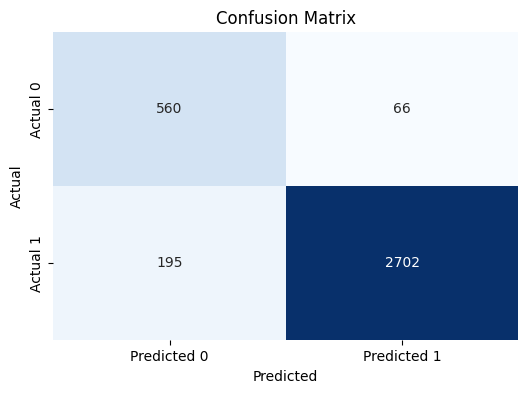

In [ ]:
cm = confusion_matrix(y_test, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()